# Read data

In [1]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
path = 'data/data.csv'
# load the dataset
dataset = pd.read_csv(path)

In [2]:
dataset.head()

,title,category,content
0,Galaxy Gear có thể điều khiển TV thông minh,Công nghệ,Mẫu đồng hồ thông minh Galaxy Gear của Samsung...
1,Nhật – Mỹ định hội đàm chớp nhoáng tại Singapo...,Thế giới,">> Phó Tổng thống Mỹ công du châu Á, bàn về Bi..."
2,Hàng ngàn học sinh miền núi Nghệ An bỏ học,Giáo dục,Hàng ngàn học sinh sau khi tốt nghiệp THCS đã ...
3,'Cô ấy bỏ em vì... em gái trượt đại học?',Đời sống,Mr Búp Bê (BB): Hay là bạn phải đến kèm cho cô...
4,Cậu bé vượt qua Face ID của iPhone ngang anh Q...,Công nghệ,Trang Wired mới đây đưa thông tin cậu bé Ammar...


## Create column title and content

In [4]:
dataset['total'] = dataset['title']+' '+dataset['content']

In [4]:
dataset.head()

,title,category,content,total
0,Galaxy Gear có thể điều khiển TV thông minh,Công nghệ,Mẫu đồng hồ thông minh Galaxy Gear của Samsung...,Galaxy Gear có thể điều khiển TV thông minh Mẫ...
1,Nhật – Mỹ định hội đàm chớp nhoáng tại Singapo...,Thế giới,">> Phó Tổng thống Mỹ công du châu Á, bàn về Bi...",Nhật – Mỹ định hội đàm chớp nhoáng tại Singapo...
2,Hàng ngàn học sinh miền núi Nghệ An bỏ học,Giáo dục,Hàng ngàn học sinh sau khi tốt nghiệp THCS đã ...,Hàng ngàn học sinh miền núi Nghệ An bỏ học Hàn...
3,'Cô ấy bỏ em vì... em gái trượt đại học?',Đời sống,Mr Búp Bê (BB): Hay là bạn phải đến kèm cho cô...,'Cô ấy bỏ em vì... em gái trượt đại học?' Mr B...
4,Cậu bé vượt qua Face ID của iPhone ngang anh Q...,Công nghệ,Trang Wired mới đây đưa thông tin cậu bé Ammar...,Cậu bé vượt qua Face ID của iPhone ngang anh Q...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51999 entries, 0 to 51998
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     51999 non-null  object
 1   category  51999 non-null  object
 2   content   51999 non-null  object
 3   total     51999 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [16]:
labels = dataset.category.unique().tolist()

# Preprocessing

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(dataset.category)

In [5]:
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['total'], label, test_size=0.2, random_state=42)

## TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer()
#Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

## Binary

In [24]:
#Initialize the `binary_vectorizer` 
b_vectorizer = CountVectorizer(binary=True)
#Fit and transform the training data 
b_train = b_vectorizer.fit_transform(X_train)
#Transform the test set 
b_test = b_vectorizer.transform(X_test)

## Count

In [8]:
#Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer()
#Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train)
#Transform the test set 
count_test = count_vectorizer.transform(X_test)

## Continuous Bag-of-Words (CBOW)

In [9]:
model = Word2Vec(sentences=dataset['total'], window=3)

In [10]:
def get_sentence_vector(sentence):
    # Khởi tạo vector
    vector = np.zeros(model.vector_size)
    # Đếm số từ trong câu
    count = 0
    # Tính tổng vector từ trong câu
    for word in sentence:
        if word in model.wv.key_to_index:
            vector += model.wv[word]
            count += 1
    # Trả về vector trung bình
    if count > 0:
        vector /= count
    return vector

In [11]:
w2v_train = [get_sentence_vector(i) for i in tqdm(X_train)]
w2v_test = [get_sentence_vector(i) for i in tqdm(X_test)]

  0%|          | 0/41599 [00:00<?, ?it/s]

  0%|          | 0/10400 [00:00<?, ?it/s]

# Models

## Plot confusion matrix

In [19]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes=labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Naive Bayes

### TF-IDF

In [17]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
NB_TF = MultinomialNB()
NB_TF.fit(tfidf_train, y_train)
pred_NB_TF = NB_TF.predict(tfidf_test)

In [21]:
print(classification_report(y_test, pred_NB_TF, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.94      0.68      0.79       790
    Thế giới       0.81      0.91      0.86       775
    Giáo dục       0.77      0.88      0.82       792
    Đời sống       0.86      0.66      0.75       779
      Xã hội       0.72      0.75      0.74       808
     Kinh tế       0.68      0.84      0.75       819
    Khoa học       0.74      0.75      0.75       798
     Nhà đất       0.87      0.84      0.86       822
    Thể thao       0.98      0.94      0.96       817
     Văn hóa       0.68      0.63      0.66       796
   Pháp luật       0.97      0.82      0.89       833
    Giải trí       0.62      0.64      0.63       782
       Xe cộ       0.71      0.85      0.77       789

    accuracy                           0.79     10400
   macro avg       0.80      0.79      0.79     10400
weighted avg       0.80      0.79      0.79     10400



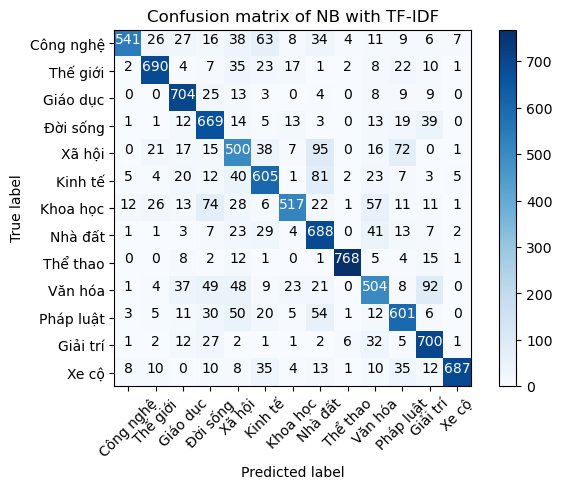

In [26]:
plot_confusion_matrix(confusion_matrix(y_test, pred_NB_TF, labels=le.transform(labels)), title='Confusion matrix of NB with TF-IDF')

### Count

In [27]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
NB_C = MultinomialNB()
NB_C.fit(count_train, y_train)
pred_NB_C = NB_C.predict(count_test)

In [29]:
print(classification_report(y_test, pred_NB_C, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.89      0.76      0.82       790
    Thế giới       0.86      0.87      0.86       775
    Giáo dục       0.78      0.89      0.83       792
    Đời sống       0.80      0.79      0.80       779
      Xã hội       0.76      0.75      0.75       808
     Kinh tế       0.74      0.78      0.76       819
    Khoa học       0.73      0.78      0.75       798
     Nhà đất       0.88      0.87      0.87       822
    Thể thao       0.98      0.95      0.97       817
     Văn hóa       0.65      0.66      0.66       796
   Pháp luật       0.95      0.86      0.90       833
    Giải trí       0.62      0.62      0.62       782
       Xe cộ       0.77      0.81      0.79       789

    accuracy                           0.80     10400
   macro avg       0.80      0.80      0.80     10400
weighted avg       0.80      0.80      0.80     10400



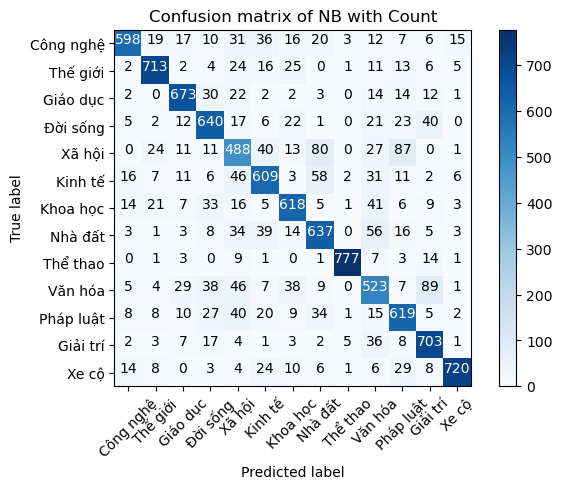

In [30]:
plot_confusion_matrix(confusion_matrix(y_test, pred_NB_C, labels=le.transform(labels)), title='Confusion matrix of NB with Count')

### Binary

In [28]:
NB_B = MultinomialNB()
NB_B.fit(b_train, y_train)
pred_NB_B = NB_B.predict(b_test)

In [29]:
print(classification_report(y_test, pred_NB_B, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.91      0.70      0.79       790
    Thế giới       0.76      0.80      0.78       775
    Giáo dục       0.76      0.87      0.81       792
    Đời sống       0.80      0.74      0.77       779
      Xã hội       0.67      0.75      0.71       808
     Kinh tế       0.69      0.76      0.72       819
    Khoa học       0.73      0.75      0.74       798
     Nhà đất       0.86      0.88      0.87       822
    Thể thao       0.99      0.92      0.95       817
     Văn hóa       0.63      0.62      0.62       796
   Pháp luật       0.95      0.80      0.87       833
    Giải trí       0.59      0.61      0.60       782
       Xe cộ       0.72      0.75      0.73       789

    accuracy                           0.77     10400
   macro avg       0.77      0.76      0.77     10400
weighted avg       0.77      0.77      0.77     10400



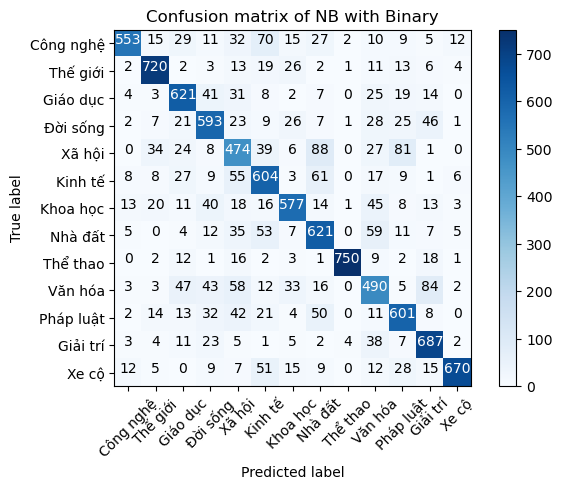

In [33]:
plot_confusion_matrix(confusion_matrix(y_test, pred_NB_B, labels=le.transform(labels)), title='Confusion matrix of NB with Binary')

### CBOW

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
NB_WV = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
NB_WV.fit(w2v_train,y_train)
pred_NB_WV = NB_WV.predict(w2v_test)

In [34]:
print(classification_report(y_test, pred_NB_WV, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.30      0.24      0.27       790
    Thế giới       0.40      0.20      0.27       775
    Giáo dục       0.31      0.20      0.25       792
    Đời sống       0.22      0.22      0.22       779
      Xã hội       0.27      0.26      0.26       808
     Kinh tế       0.39      0.18      0.25       819
    Khoa học       0.46      0.27      0.34       798
     Nhà đất       0.55      0.23      0.32       822
    Thể thao       0.34      0.50      0.40       817
     Văn hóa       0.20      0.10      0.13       796
   Pháp luật       0.43      0.45      0.44       833
    Giải trí       0.25      0.20      0.22       782
       Xe cộ       0.19      0.72      0.30       789

    accuracy                           0.29     10400
   macro avg       0.33      0.29      0.28     10400
weighted avg       0.33      0.29      0.28     10400



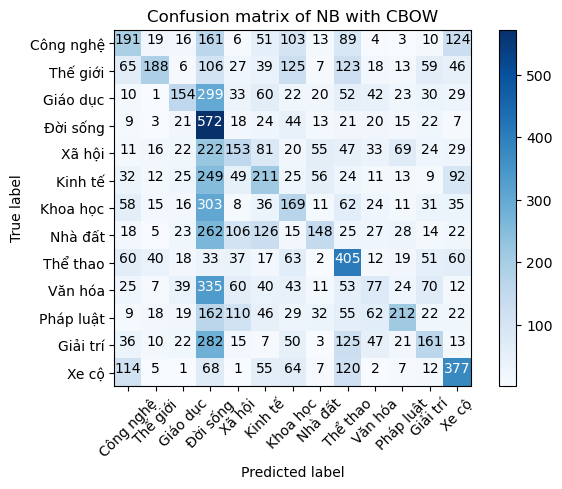

In [35]:
plot_confusion_matrix(confusion_matrix(y_test, pred_NB_WV, labels=le.transform(labels)), title='Confusion matrix of NB with CBOW')

## LR

### TF-IDF

In [36]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
LR_TF = LogisticRegression()
LR_TF.fit(tfidf_train, y_train)
pred_LR_TF = LR_TF.predict(tfidf_test)

C:\Users\XingStar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
print(classification_report(y_test, pred_LR_TF, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.86      0.82      0.84       790
    Thế giới       0.89      0.90      0.89       775
    Giáo dục       0.85      0.85      0.85       792
    Đời sống       0.77      0.83      0.80       779
      Xã hội       0.79      0.78      0.79       808
     Kinh tế       0.81      0.82      0.81       819
    Khoa học       0.80      0.79      0.80       798
     Nhà đất       0.88      0.88      0.88       822
    Thể thao       0.96      0.97      0.97       817
     Văn hóa       0.72      0.73      0.73       796
   Pháp luật       0.93      0.91      0.92       833
    Giải trí       0.70      0.66      0.68       782
       Xe cộ       0.80      0.83      0.82       789

    accuracy                           0.83     10400
   macro avg       0.83      0.83      0.83     10400
weighted avg       0.83      0.83      0.83     10400



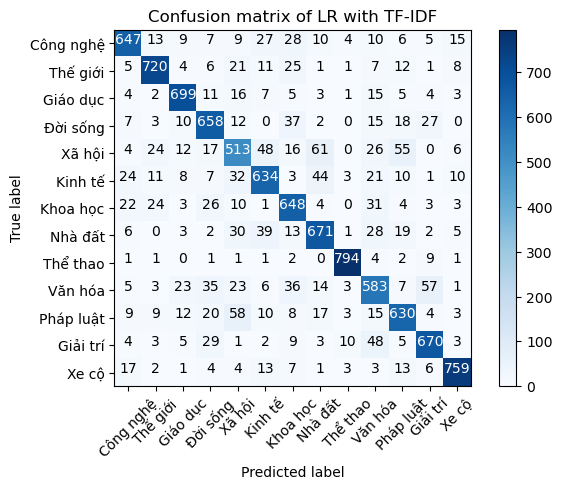

In [38]:
plot_confusion_matrix(confusion_matrix(y_test, pred_LR_TF, labels=le.transform(labels)), title='Confusion matrix of LR with TF-IDF')

### Count

In [39]:
LR_C = LogisticRegression()
LR_C.fit(count_train, y_train)
pred_LR_C = LR_C.predict(count_test)

C:\Users\XingStar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
print(classification_report(y_test, pred_LR_C, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.82      0.80      0.81       790
    Thế giới       0.86      0.87      0.86       775
    Giáo dục       0.78      0.80      0.79       792
    Đời sống       0.75      0.75      0.75       779
      Xã hội       0.75      0.74      0.75       808
     Kinh tế       0.77      0.80      0.78       819
    Khoa học       0.75      0.75      0.75       798
     Nhà đất       0.86      0.84      0.85       822
    Thể thao       0.93      0.95      0.94       817
     Văn hóa       0.68      0.66      0.67       796
   Pháp luật       0.90      0.89      0.89       833
    Giải trí       0.64      0.63      0.63       782
       Xe cộ       0.76      0.76      0.76       789

    accuracy                           0.79     10400
   macro avg       0.79      0.79      0.79     10400
weighted avg       0.79      0.79      0.79     10400



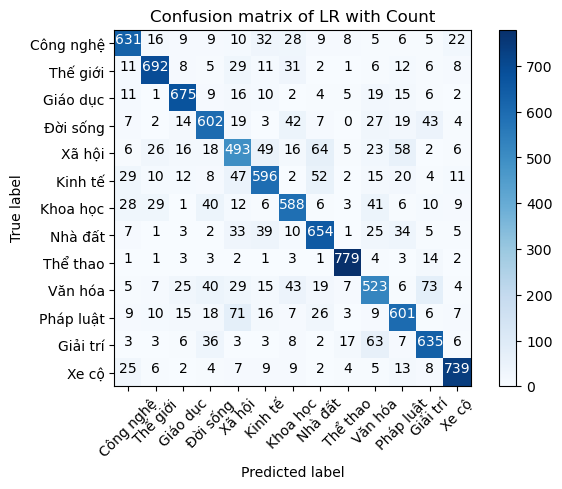

In [41]:
plot_confusion_matrix(confusion_matrix(y_test, pred_LR_C, labels=le.transform(labels)), title='Confusion matrix of LR with Count')

### Binary

In [32]:
LR_B = LogisticRegression()
LR_B.fit(b_train, y_train)
pred_LR_B = LR_B.predict(b_test)

C:\Users\XingStar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
print(classification_report(y_test, pred_LR_B, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.80      0.79      0.79       790
    Thế giới       0.82      0.85      0.83       775
    Giáo dục       0.80      0.78      0.79       792
    Đời sống       0.75      0.75      0.75       779
      Xã hội       0.72      0.72      0.72       808
     Kinh tế       0.73      0.76      0.75       819
    Khoa học       0.75      0.75      0.75       798
     Nhà đất       0.84      0.84      0.84       822
    Thể thao       0.95      0.95      0.95       817
     Văn hóa       0.67      0.66      0.66       796
   Pháp luật       0.89      0.90      0.90       833
    Giải trí       0.62      0.61      0.61       782
       Xe cộ       0.76      0.74      0.75       789

    accuracy                           0.78     10400
   macro avg       0.78      0.78      0.78     10400
weighted avg       0.78      0.78      0.78     10400



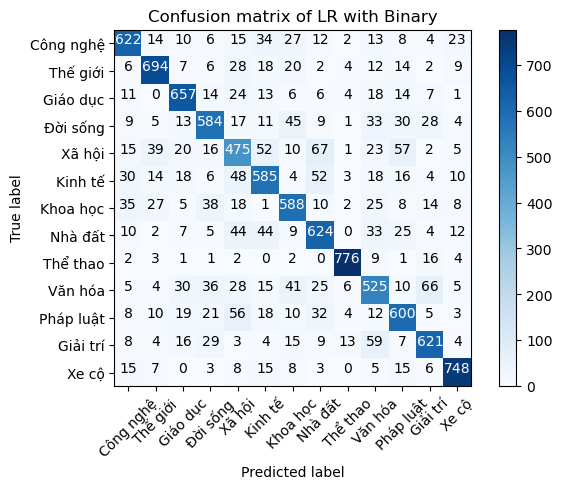

In [35]:
plot_confusion_matrix(confusion_matrix(y_test, pred_LR_B, labels=le.transform(labels)), title='Confusion matrix of LR with Binary')

### CBOW

In [42]:
LR_WV = LogisticRegression()
LR_WV.fit(w2v_train, y_train)
pred_LR_WV = LR_WV.predict(w2v_test)

C:\Users\XingStar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
print(classification_report(y_test, pred_LR_WV, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.59      0.57      0.58       790
    Thế giới       0.61      0.65      0.63       775
    Giáo dục       0.54      0.53      0.54       792
    Đời sống       0.52      0.45      0.48       779
      Xã hội       0.54      0.51      0.52       808
     Kinh tế       0.53      0.55      0.54       819
    Khoa học       0.54      0.57      0.55       798
     Nhà đất       0.66      0.63      0.65       822
    Thể thao       0.70      0.79      0.74       817
     Văn hóa       0.46      0.33      0.38       796
   Pháp luật       0.71      0.75      0.73       833
    Giải trí       0.47      0.45      0.46       782
       Xe cộ       0.47      0.61      0.53       789

    accuracy                           0.57     10400
   macro avg       0.57      0.57      0.56     10400
weighted avg       0.57      0.57      0.57     10400



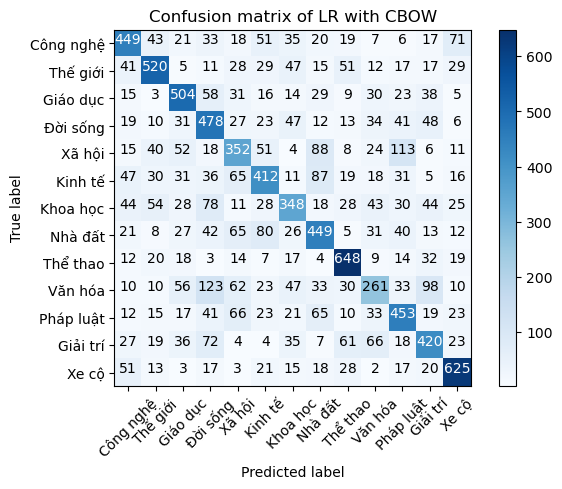

In [44]:
plot_confusion_matrix(confusion_matrix(y_test, pred_LR_WV, labels=le.transform(labels)), title='Confusion matrix of LR with CBOW')

## Decision tree

### TF-IDF

In [47]:
from sklearn.tree import DecisionTreeClassifier
DT_TF = DecisionTreeClassifier()
DT_TF.fit(tfidf_train, y_train)
pred_DT_TF = DT_TF.predict(tfidf_test)

In [48]:
print(classification_report(y_test, pred_DT_TF, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.53      0.52      0.53       790
    Thế giới       0.72      0.74      0.73       775
    Giáo dục       0.63      0.57      0.60       792
    Đời sống       0.46      0.49      0.48       779
      Xã hội       0.52      0.51      0.51       808
     Kinh tế       0.51      0.55      0.53       819
    Khoa học       0.50      0.48      0.49       798
     Nhà đất       0.55      0.54      0.54       822
    Thể thao       0.82      0.80      0.81       817
     Văn hóa       0.41      0.40      0.41       796
   Pháp luật       0.78      0.79      0.79       833
    Giải trí       0.40      0.41      0.40       782
       Xe cộ       0.54      0.54      0.54       789

    accuracy                           0.57     10400
   macro avg       0.57      0.57      0.57     10400
weighted avg       0.57      0.57      0.57     10400



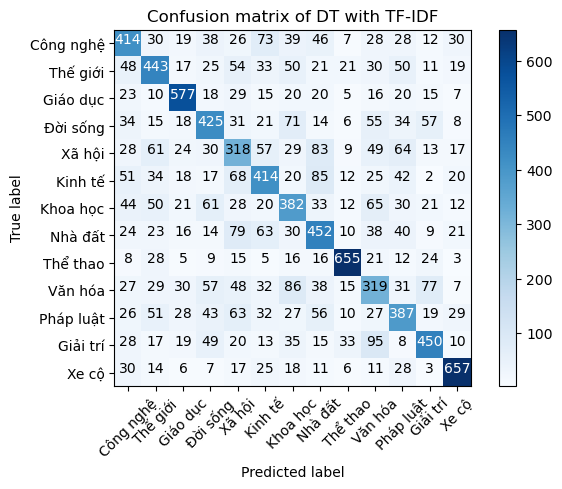

In [49]:
plot_confusion_matrix(confusion_matrix(y_test, pred_DT_TF, labels=le.transform(labels)), title='Confusion matrix of DT with TF-IDF')

### Count

In [50]:
DT_C = DecisionTreeClassifier()
DT_C.fit(count_train, y_train)
pred_DT_C = DT_C.predict(count_test)

In [51]:
print(classification_report(y_test, pred_DT_C, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.50      0.50      0.50       790
    Thế giới       0.69      0.74      0.71       775
    Giáo dục       0.63      0.61      0.62       792
    Đời sống       0.49      0.53      0.51       779
      Xã hội       0.50      0.49      0.50       808
     Kinh tế       0.53      0.52      0.53       819
    Khoa học       0.51      0.51      0.51       798
     Nhà đất       0.57      0.58      0.58       822
    Thể thao       0.85      0.83      0.84       817
     Văn hóa       0.41      0.40      0.40       796
   Pháp luật       0.77      0.79      0.78       833
    Giải trí       0.37      0.36      0.37       782
       Xe cộ       0.54      0.53      0.53       789

    accuracy                           0.57     10400
   macro avg       0.57      0.57      0.57     10400
weighted avg       0.57      0.57      0.57     10400



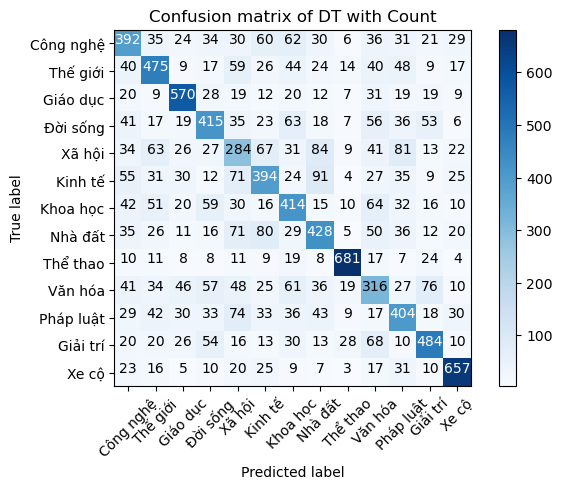

In [52]:
plot_confusion_matrix(confusion_matrix(y_test, pred_DT_C, labels=le.transform(labels)), title='Confusion matrix of DT with Count')

### Binary

In [37]:
DT_B = DecisionTreeClassifier()
DT_B.fit(b_train, y_train)
pred_DT_B = DT_B.predict(b_test)

In [38]:
print(classification_report(y_test, pred_DT_B, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.51      0.50      0.51       790
    Thế giới       0.62      0.66      0.64       775
    Giáo dục       0.60      0.58      0.59       792
    Đời sống       0.50      0.52      0.51       779
      Xã hội       0.45      0.46      0.45       808
     Kinh tế       0.47      0.48      0.47       819
    Khoa học       0.47      0.45      0.46       798
     Nhà đất       0.52      0.51      0.52       822
    Thể thao       0.84      0.83      0.83       817
     Văn hóa       0.36      0.34      0.35       796
   Pháp luật       0.75      0.77      0.76       833
    Giải trí       0.35      0.36      0.35       782
       Xe cộ       0.52      0.52      0.52       789

    accuracy                           0.54     10400
   macro avg       0.54      0.54      0.54     10400
weighted avg       0.54      0.54      0.54     10400



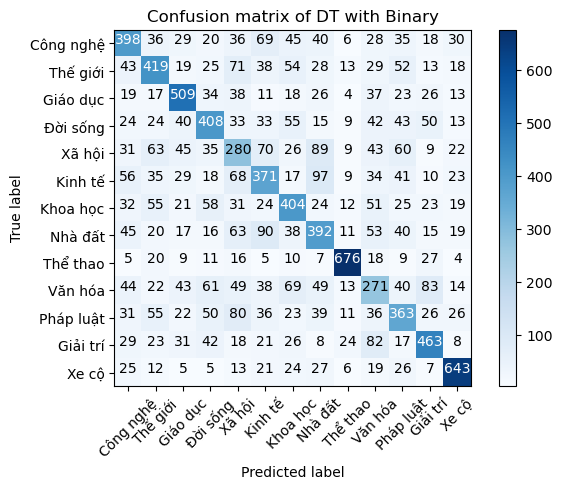

In [39]:
plot_confusion_matrix(confusion_matrix(y_test, pred_DT_B, labels=le.transform(labels)), title='Confusion matrix of DT with Binary')

### CBOW

In [53]:
DT_WV = DecisionTreeClassifier()
DT_WV.fit(w2v_train, y_train)
pred_DT_WV = DT_WV.predict(w2v_test)

In [54]:
print(classification_report(y_test, pred_DT_WV, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.30      0.33      0.32       790
    Thế giới       0.32      0.30      0.31       775
    Giáo dục       0.28      0.27      0.28       792
    Đời sống       0.20      0.21      0.20       779
      Xã hội       0.30      0.30      0.30       808
     Kinh tế       0.32      0.32      0.32       819
    Khoa học       0.27      0.28      0.27       798
     Nhà đất       0.35      0.32      0.33       822
    Thể thao       0.47      0.47      0.47       817
     Văn hóa       0.18      0.19      0.18       796
   Pháp luật       0.49      0.47      0.48       833
    Giải trí       0.26      0.28      0.27       782
       Xe cộ       0.27      0.28      0.27       789

    accuracy                           0.31     10400
   macro avg       0.31      0.31      0.31     10400
weighted avg       0.31      0.31      0.31     10400



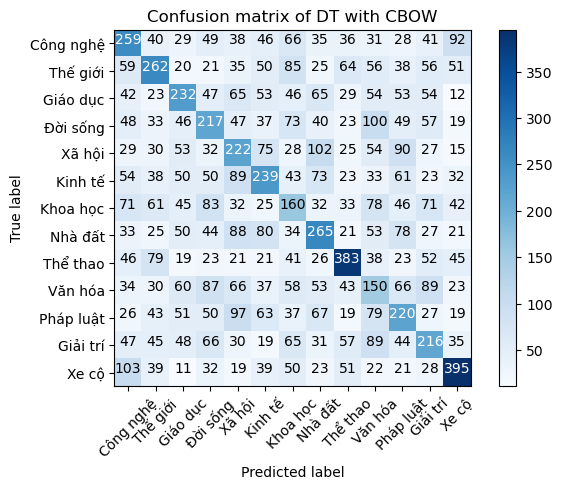

In [55]:
plot_confusion_matrix(confusion_matrix(y_test, pred_DT_WV, labels=le.transform(labels)), title='Confusion matrix of DT with CBOW')

## Random Forest

### TF-IDF

In [56]:
from sklearn.ensemble import RandomForestClassifier
RF_TF = RandomForestClassifier()
RF_TF.fit(tfidf_train, y_train)
pred_RF_TF = RF_TF.predict(tfidf_test)

In [57]:
print(classification_report(y_test, pred_RF_TF, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.81      0.69      0.74       790
    Thế giới       0.79      0.90      0.85       775
    Giáo dục       0.73      0.86      0.79       792
    Đời sống       0.71      0.77      0.74       779
      Xã hội       0.72      0.72      0.72       808
     Kinh tế       0.70      0.78      0.74       819
    Khoa học       0.72      0.77      0.75       798
     Nhà đất       0.81      0.84      0.82       822
    Thể thao       0.94      0.96      0.95       817
     Văn hóa       0.72      0.55      0.62       796
   Pháp luật       0.89      0.88      0.88       833
    Giải trí       0.71      0.54      0.62       782
       Xe cộ       0.77      0.78      0.77       789

    accuracy                           0.77     10400
   macro avg       0.77      0.77      0.77     10400
weighted avg       0.77      0.77      0.77     10400



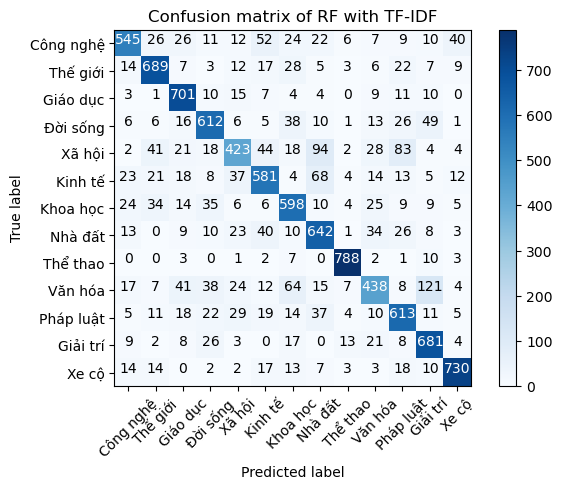

In [58]:
plot_confusion_matrix(confusion_matrix(y_test, pred_RF_TF, labels=le.transform(labels)), title='Confusion matrix of RF with TF-IDF')

### Count

In [59]:
RF_C = RandomForestClassifier()
RF_C.fit(count_train, y_train)
pred_RF_C = RF_C.predict(count_test)

In [60]:
print(classification_report(y_test, pred_RF_C, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.83      0.67      0.74       790
    Thế giới       0.77      0.91      0.83       775
    Giáo dục       0.73      0.87      0.79       792
    Đời sống       0.70      0.74      0.72       779
      Xã hội       0.69      0.72      0.71       808
     Kinh tế       0.70      0.78      0.73       819
    Khoa học       0.71      0.75      0.73       798
     Nhà đất       0.80      0.86      0.83       822
    Thể thao       0.94      0.96      0.95       817
     Văn hóa       0.73      0.50      0.59       796
   Pháp luật       0.89      0.88      0.89       833
    Giải trí       0.71      0.52      0.60       782
       Xe cộ       0.74      0.77      0.75       789

    accuracy                           0.76     10400
   macro avg       0.76      0.76      0.76     10400
weighted avg       0.76      0.76      0.76     10400



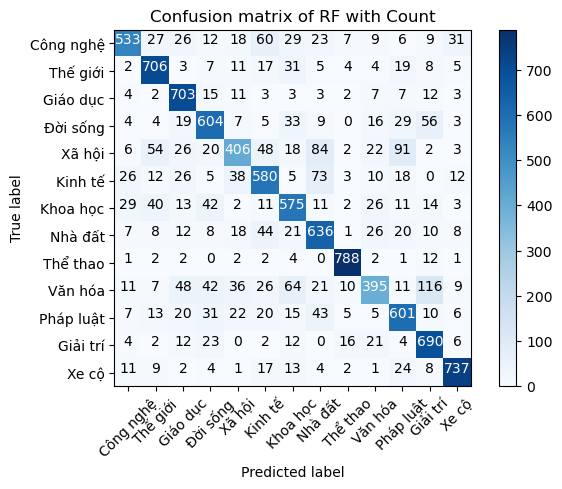

In [61]:
plot_confusion_matrix(confusion_matrix(y_test, pred_RF_C, labels=le.transform(labels)), title='Confusion matrix of RF with Count')

### Binary

In [41]:
RF_B = RandomForestClassifier()
RF_B.fit(b_train, y_train)
pred_RF_B = RF_B.predict(b_test)

In [42]:
print(classification_report(y_test, pred_RF_B, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.83      0.68      0.75       790
    Thế giới       0.75      0.89      0.81       775
    Giáo dục       0.71      0.85      0.77       792
    Đời sống       0.70      0.74      0.72       779
      Xã hội       0.65      0.70      0.67       808
     Kinh tế       0.66      0.76      0.71       819
    Khoa học       0.73      0.77      0.75       798
     Nhà đất       0.81      0.86      0.83       822
    Thể thao       0.93      0.96      0.95       817
     Văn hóa       0.71      0.47      0.56       796
   Pháp luật       0.91      0.86      0.89       833
    Giải trí       0.66      0.48      0.56       782
       Xe cộ       0.76      0.77      0.76       789

    accuracy                           0.75     10400
   macro avg       0.75      0.75      0.75     10400
weighted avg       0.76      0.75      0.75     10400



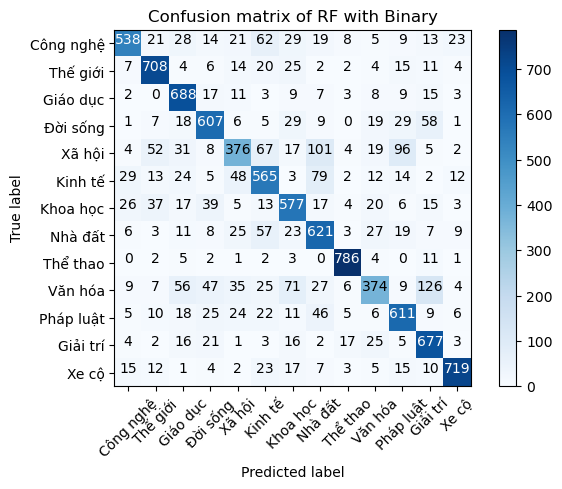

In [43]:
plot_confusion_matrix(confusion_matrix(y_test, pred_RF_B, labels=le.transform(labels)), title='Confusion matrix of RF with Binary')

### CBOW

In [62]:
RF_WV = RandomForestClassifier()
RF_WV.fit(w2v_train, y_train)
pred_RF_WV = RF_WV.predict(w2v_test)

In [63]:
print(classification_report(y_test, pred_RF_WV, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.55      0.48      0.51       790
    Thế giới       0.55      0.59      0.57       775
    Giáo dục       0.45      0.48      0.46       792
    Đời sống       0.44      0.42      0.43       779
      Xã hội       0.48      0.47      0.48       808
     Kinh tế       0.52      0.52      0.52       819
    Khoa học       0.48      0.53      0.51       798
     Nhà đất       0.58      0.61      0.59       822
    Thể thao       0.62      0.74      0.68       817
     Văn hóa       0.42      0.28      0.33       796
   Pháp luật       0.67      0.68      0.68       833
    Giải trí       0.49      0.41      0.45       782
       Xe cộ       0.48      0.55      0.51       789

    accuracy                           0.52     10400
   macro avg       0.52      0.52      0.52     10400
weighted avg       0.52      0.52      0.52     10400



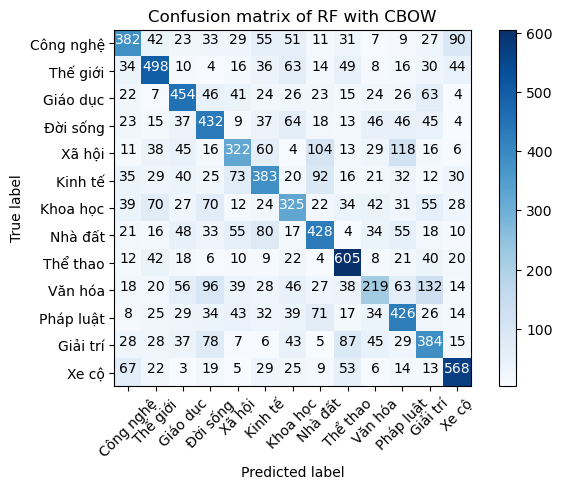

In [64]:
plot_confusion_matrix(confusion_matrix(y_test, pred_RF_WV, labels=le.transform(labels)), title='Confusion matrix of RF with CBOW')

## SVM

### TF-IDF

In [13]:
# SVM
from sklearn.svm import SVC
SVM_TF = SVC()
SVM_TF.fit(tfidf_train, y_train)
pred_SVM_TF = SVM_TF.predict(tfidf_test)

In [74]:
print(classification_report(y_test, pred_SVM_TF, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.84      0.82      0.83       790
    Thế giới       0.87      0.91      0.89       775
    Giáo dục       0.84      0.84      0.84       792
    Đời sống       0.78      0.84      0.81       779
      Xã hội       0.81      0.78      0.80       808
     Kinh tế       0.81      0.84      0.82       819
    Khoa học       0.83      0.77      0.80       798
     Nhà đất       0.88      0.88      0.88       822
    Thể thao       0.97      0.98      0.97       817
     Văn hóa       0.73      0.73      0.73       796
   Pháp luật       0.93      0.92      0.92       833
    Giải trí       0.72      0.68      0.70       782
       Xe cộ       0.81      0.84      0.82       789

    accuracy                           0.83     10400
   macro avg       0.83      0.83      0.83     10400
weighted avg       0.83      0.83      0.83     10400



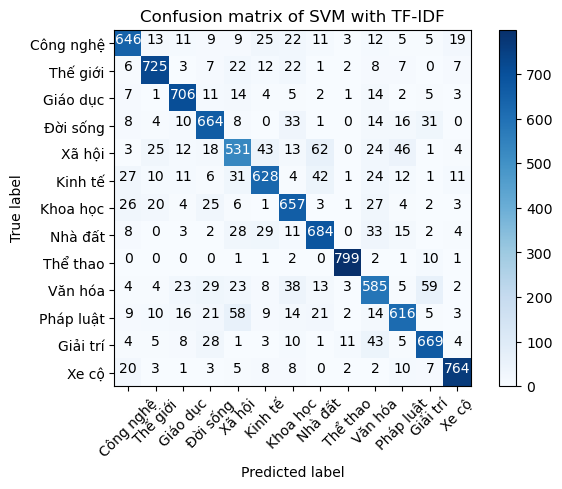

In [75]:
plot_confusion_matrix(confusion_matrix(y_test, pred_SVM_TF, labels=le.transform(labels)), title='Confusion matrix of SVM with TF-IDF')

### Count

In [14]:
SVM_C = SVC()
SVM_C.fit(count_train, y_train)
pred_SVM_C = SVM_C.predict(count_test)

In [17]:
print(classification_report(y_test, pred_SVM_C, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.82      0.78      0.80       790
    Thế giới       0.87      0.87      0.87       775
    Giáo dục       0.83      0.81      0.82       792
    Đời sống       0.59      0.81      0.68       779
      Xã hội       0.80      0.76      0.78       808
     Kinh tế       0.82      0.80      0.81       819
    Khoa học       0.79      0.75      0.77       798
     Nhà đất       0.87      0.83      0.85       822
    Thể thao       0.97      0.93      0.95       817
     Văn hóa       0.68      0.69      0.68       796
   Pháp luật       0.91      0.86      0.88       833
    Giải trí       0.63      0.64      0.63       782
       Xe cộ       0.81      0.79      0.80       789

    accuracy                           0.79     10400
   macro avg       0.80      0.79      0.79     10400
weighted avg       0.80      0.79      0.80     10400



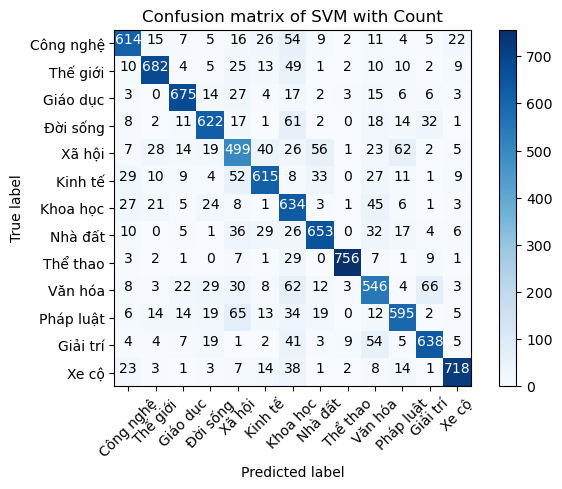

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, pred_SVM_C, labels=le.transform(labels)), title='Confusion matrix of SVM with Count')

### Binary

In [44]:
from sklearn.svm import SVC
SVM_B = SVC()
SVM_B.fit(b_train, y_train)
pred_SVM_B = SVM_B.predict(b_test)

In [45]:
print(classification_report(y_test, pred_SVM_B, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.83      0.79      0.81       790
    Thế giới       0.85      0.89      0.87       775
    Giáo dục       0.82      0.82      0.82       792
    Đời sống       0.69      0.81      0.75       779
      Xã hội       0.77      0.75      0.76       808
     Kinh tế       0.80      0.83      0.82       819
    Khoa học       0.79      0.78      0.79       798
     Nhà đất       0.86      0.86      0.86       822
    Thể thao       0.97      0.95      0.96       817
     Văn hóa       0.70      0.70      0.70       796
   Pháp luật       0.91      0.89      0.90       833
    Giải trí       0.69      0.62      0.65       782
       Xe cộ       0.81      0.79      0.80       789

    accuracy                           0.81     10400
   macro avg       0.81      0.81      0.81     10400
weighted avg       0.81      0.81      0.81     10400



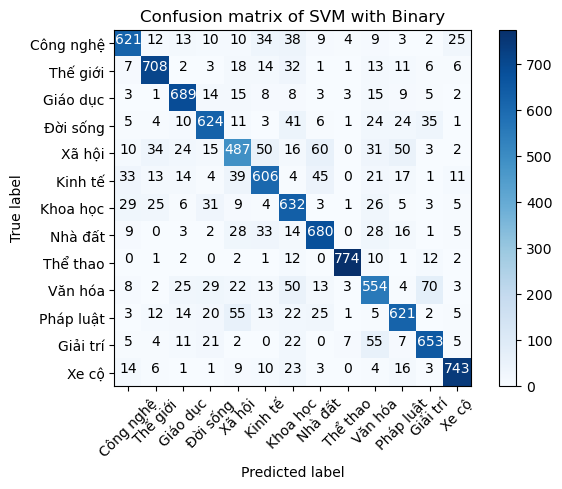

In [46]:
plot_confusion_matrix(confusion_matrix(y_test, pred_SVM_B, labels=le.transform(labels)), title='Confusion matrix of SVM with Binary')

### CBOW

In [21]:
SVM_WV = SVC()
SVM_WV.fit(w2v_train, y_train)
pred_SVM_WV = SVM_WV.predict(w2v_test)

In [22]:
print(classification_report(y_test, pred_SVM_WV, target_names=labels))

              precision    recall  f1-score   support

   Công nghệ       0.63      0.57      0.60       790
    Thế giới       0.65      0.61      0.63       775
    Giáo dục       0.52      0.57      0.55       792
    Đời sống       0.49      0.46      0.47       779
      Xã hội       0.55      0.53      0.54       808
     Kinh tế       0.55      0.55      0.55       819
    Khoa học       0.55      0.58      0.57       798
     Nhà đất       0.68      0.64      0.66       822
    Thể thao       0.71      0.82      0.76       817
     Văn hóa       0.45      0.34      0.39       796
   Pháp luật       0.73      0.75      0.74       833
    Giải trí       0.48      0.45      0.46       782
       Xe cộ       0.47      0.61      0.53       789

    accuracy                           0.58     10400
   macro avg       0.57      0.58      0.57     10400
weighted avg       0.58      0.58      0.57     10400



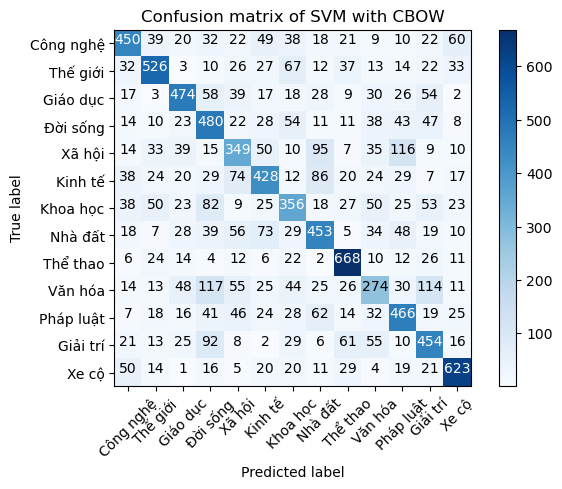

In [23]:
plot_confusion_matrix(confusion_matrix(y_test, pred_SVM_WV, labels=le.transform(labels)), title='Confusion matrix of SVM with CBOW')